In [17]:
import pandas as pd
import numpy as np
from timesmash import XHMMFeatures, SymbolicDerivative, InferredHMMLikelihood, Quantizer, LikelihoodDistance
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from patternly.detection import StreamingDetection, AnomalyDetection
from datetime import datetime, timedelta

agitations = pd.read_csv("./agitations.csv")#.dropna(how="any", axis=0)
# agitations[agitations["Type"] == "mild"]["Session ID"].astype(int)
# agitations[agitations["Session ID"] == 1292105]
agitations[agitations["Patient ID"] != "07-B-S"]#["Session ID"]
agitations = agitations[agitations["Session ID"].notna()]
agitations

,Device,Patient ID,Date,Start Time,End Time,Type,Responsive,Randomness,Session ID,Start Timestamp,End Timestamp
1,A03467,06-L-G,5/7/2021,11:32:15,11:33:15,mild,verbally non-aggressive,in response to external stimulus,1278732.0,1.620405e+09,NaN
2,A03724,07-B-S,5/8/2021,8:00:00,8:01:00,mild,physically non-aggressive,in response to external stimulus,1279304.0,1.620479e+09,NaN
3,A03724,07-B-S,5/8/2021,8:44:00,8:45:00,mild,verbally non-aggressive,in response to external stimulus,1279304.0,1.620481e+09,NaN
4,A03724,07-B-S,5/8/2021,9:11:00,9:12:00,mild,verbally non-aggressive,in response to external stimulus,1279304.0,1.620483e+09,NaN
5,A03724,07-B-S,5/8/2021,13:48:00,13:49:00,mild,verbally non-aggressive,in response to external stimulus,1279304.0,1.620500e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...
80,A03724,29-D-H,8/25/2021,12:04:00,12:07:00,mild,verbally aggressive,in response to external stimuli,1353517.0,1.629911e+09,1.629911e+09
81,A03724,29-D-H,8/26/2021,11:00:00,11:15:00,mild,verbally aggressive,in response to external stimuli,1354078.0,1.629994e+09,1.629994e+09
82,A03724,29-D-H,8/27/2021,9:00:00,9:15:00,mild,verbally non-aggressive,in response to external stimuli,1354616.0,1.630073e+09,1.630074e+09
85,A03724,29-D-H,9/3/2021,16:30:00,17:00:00,mild,verbally aggressive,in response to external stimuli,1358134.0,1.630705e+09,1.630706e+09


In [2]:
DATA_CATEGORIES = ["ACC_X", "ACC_Y", "ACC_Z", "BVP", "EDA", "HR"]
SESSION_ID = "1289618" # 1/2 agitations
# SESSION_ID = "1278732" # early agitation
# SESSION_ID = "1292105" # good results
# SESSION_ID = "1319589"
# SESSION_ID = "1279304"
# SESSION_ID = "1290690"
SESSION_ID = "1287403"

# SESSION_ID_TRAIN = "1313868"
# SESSION_ID_TEST = "1313868"
SESSION_ID_TRAIN = "1319059"
# SESSION_ID_TRAIN = "1321599"
SESSION_ID_TEST = "1319059" # ask about data - no change in accelerometers

SESSION_ID_TRAIN = "1276665" # new device label?
SESSION_ID_TEST = "1278732" 

SESSION_ID_TRAIN = "1355555"
SESSION_ID_TEST = "1355555" 

def read_in_data(session_id):
    original = {}
    start_ts = 0
    hz = []
    
    for category in DATA_CATEGORIES:
        file = category
        if category[0:3] == "ACC":
            file = "ACC"
        curr = pd.read_csv(f"./data/{session_id}/{file}.csv", sep=",", low_memory=False, header=None)
        if file == "ACC":
            if category[len(category) - 1] == "X":
                curr = curr.drop([1,2], axis=1)
            elif category[len(category) - 1] == "Y":
                curr = curr.drop([0,2], axis=1)
            elif category[len(category) - 1] == "Z":
                curr = curr.drop([0,1], axis=1)
        original[category] = curr
        start_ts = original[category].iloc[0,0]
        hz.append(original[category].iloc[1,0])
        original[category] = original[category].iloc[2:].reset_index(drop=True)
        
    return original, start_ts, hz

train_original, train_start_ts, hz = read_in_data(SESSION_ID_TRAIN)
test_original, test_start_ts, hz = read_in_data(SESSION_ID_TEST)
agitation_start_ts = agitations[agitations["Session ID"] == float(SESSION_ID_TEST)]["Start Timestamp"].values.tolist()
agitation_end_ts = agitations[agitations["Session ID"] == float(SESSION_ID_TEST)]["End Timestamp"].values.tolist()

In [3]:
agitation_num = 1
print(str(datetime.fromtimestamp(train_start_ts)))
train_date = str(datetime.fromtimestamp(train_start_ts)).split(' ')[0]
train_time = str(datetime.fromtimestamp(agitation_start_ts[agitation_num])).split(' ')[1]
new_train_time = datetime.fromisoformat(f"{train_date} {train_time}")
if datetime.fromtimestamp(train_start_ts) > new_train_time:
    new_train_time += timedelta(days=1)
    
print(new_train_time)

2021-08-28 18:47:34
2021-08-28 20:20:00


In [4]:
%%time
from datetime import datetime

WINDOW_SIZE = (np.full((len(DATA_CATEGORIES)), 60 * 2) * hz).astype(np.int)
WINDOW_OVERLAP = (np.full((len(DATA_CATEGORIES)), 60 * 1.5) * hz).astype(np.int)
N_CLUSTERS = 8
QUANTIZE_TYPE = "simple"
EPS = 0.05
VERBOSE = True
# new_start_ts = min(start_ts, agitation_ts[0] - 60 * 360)
# new_end_ts = min(agitation_ts[0] - 60 * 120, new_start_ts + 60 * 180)
# diff_start = new_start_ts - start_ts
# diff_end = (end_ts - new_end_ts)

# new_start_ts = max(start_ts, agitation_ts[0] - 60 * 120)
# end_ts = start_ts + original["HR"].shape[0]
# new_end_ts = min(agitation_ts[0] + 60 * 120, end_ts)
# diff_start = new_start_ts - start_ts
# diff_end = (end_ts - new_end_ts)

train_end_ts = train_start_ts + train_original["HR"].shape[0]
new_train_time = datetime.fromisoformat(f"{train_date} {train_time}")
if datetime.fromtimestamp(train_start_ts) > new_train_time:
    new_train_time += timedelta(days=1)

train_date = str(datetime.fromtimestamp(train_start_ts)).split(' ')[0]
train_time = str(datetime.fromtimestamp(agitation_start_ts[agitation_num])).split(' ')[1]
new_train_start_ts = max(train_start_ts, new_train_time.timestamp() - (60 * 300))
new_train_end_ts = min(new_train_start_ts + (60 * 300), agitation_start_ts[agitation_num] - (60 * 120))
train_start_index = new_train_start_ts - train_start_ts
train_end_index = (train_end_ts - train_start_ts) - (train_end_ts - new_train_end_ts)


data = {}
pipelines = []
for i, category in enumerate(DATA_CATEGORIES):
#     if i == 3:
#         break
    data[category] = train_original[category].iloc[
        int(train_start_index*hz[i]):int((train_end_index*hz[i])),
        :
    ].reset_index(drop=True)
    pipeline = None
    if QUANTIZE_TYPE == "simple":
        pipeline = StreamingDetection(
            window_size=WINDOW_SIZE[i],
            window_overlap=WINDOW_OVERLAP[i],
            n_clusters=N_CLUSTERS,
            reduce_clusters=True,
            quantize_type="simple",
            eps=EPS,
            verbose=VERBOSE,
        )
        new_data = data[category]
    else:
        split_data = StreamingDetection.split_streams(data[category], WINDOW_SIZE[i], WINDOW_OVERLAP[i])
        q = Quantizer(n_quantizations=1).fit(split_data)
        new_data = next(q.transform(split_data))
        pipeline = AnomalyDetection(
            n_clusters=N_CLUSTERS,
            quantize=False,
            eps=EPS,
            verbose=VERBOSE,
        )

    pipelines.append(pipeline.fit(new_data))

Splitting data into individual streams...
Quantizing...
Calculating distance matrix...
Clustering distance matrix...
Generating cluster PFSA 1/8...
Generating cluster PFSA 2/8...
Generating cluster PFSA 3/8...
Generating cluster PFSA 4/8...
Generating cluster PFSA 5/8...
Generating cluster PFSA 6/8...
Generating cluster PFSA 7/8...
Generating cluster PFSA 8/8...
Attempting to reduce clusters...
Reduced clusters from 8 to 7.
Clustering distance matrix...
Generating cluster PFSA 1/7...
Generating cluster PFSA 2/7...
Generating cluster PFSA 3/7...
Generating cluster PFSA 4/7...
Generating cluster PFSA 5/7...
Generating cluster PFSA 6/7...
Generating cluster PFSA 7/7...
Calculating cluster PFSA means and stds...
Model fit.
Splitting data into individual streams...
Quantizing...
Calculating distance matrix...
Clustering distance matrix...
Generating cluster PFSA 1/8...
Generating cluster PFSA 2/8...
Generating cluster PFSA 3/8...
Generating cluster PFSA 4/8...
Generating cluster PFSA 5/8...

In [5]:
# print(datetime.fromtimestamp(agitation_ts[0]))
# print(datetime.fromtimestamp(new_train_start_ts))
# print(datetime.fromtimestamp(train_start_ts))
# print(datetime.fromtimestamp(new_train_end_ts))
WINDOW_SIZE

array([3840, 3840, 3840, 7680,  480,  120])

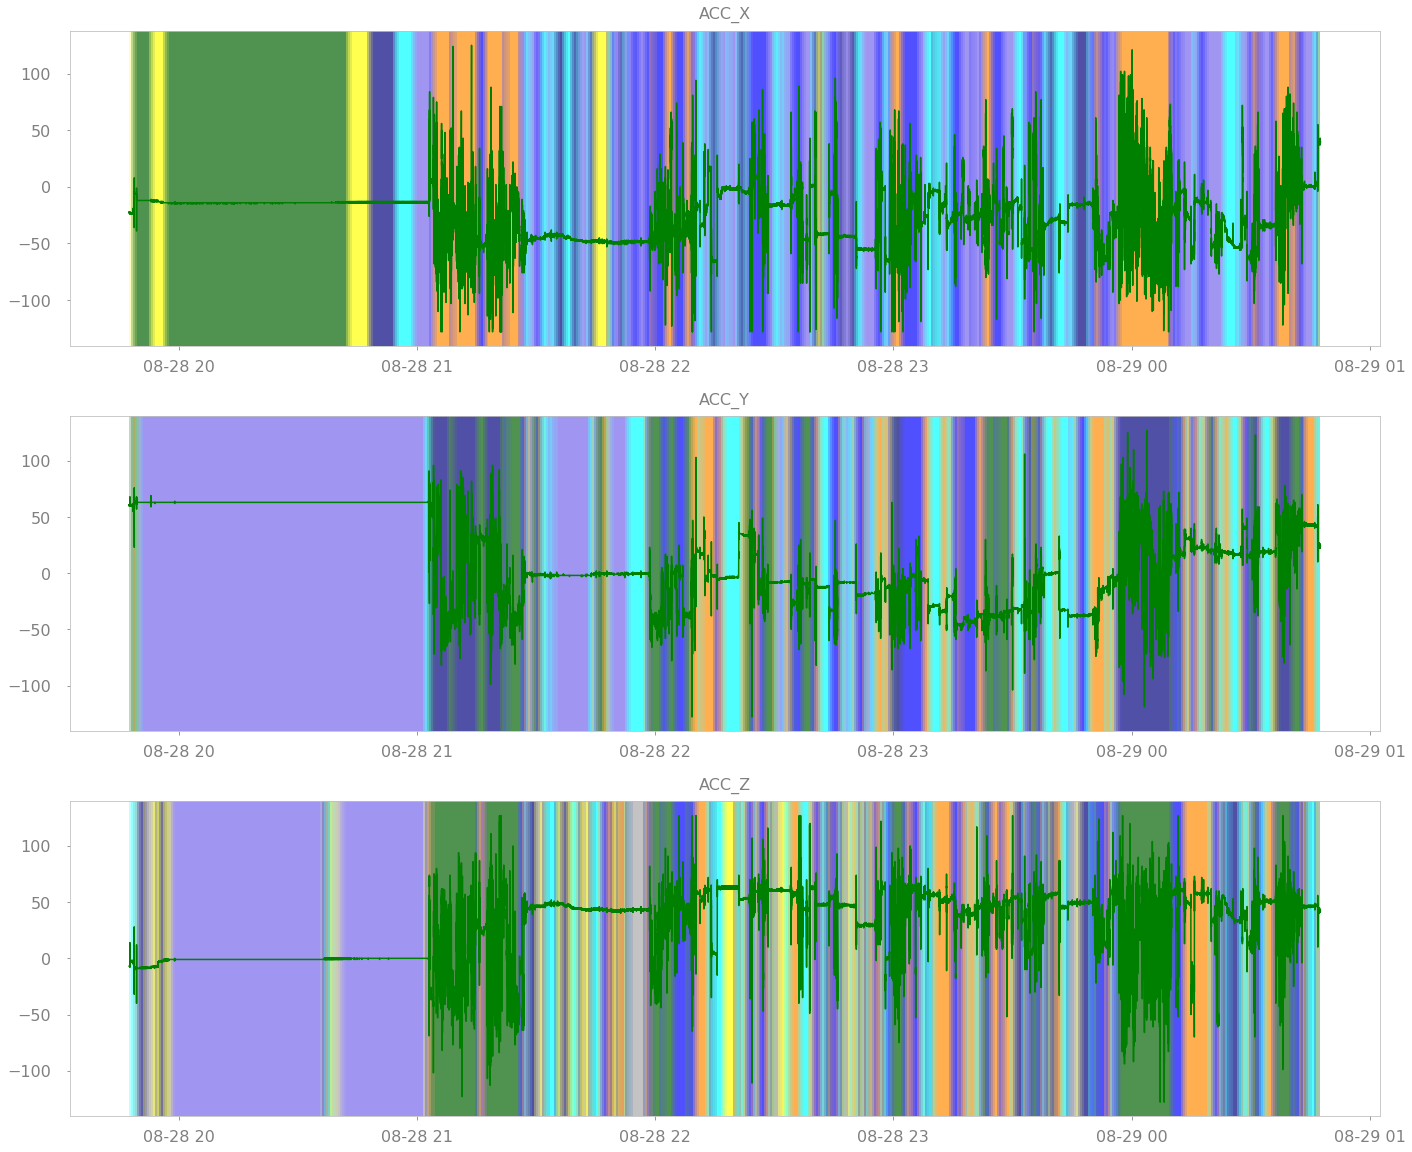

CPU times: user 30.1 s, sys: 1.1 s, total: 31.2 s
Wall time: 30.4 s


In [6]:
%%time

import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams["figure.figsize"] = (20, 32)

for i, category in enumerate(DATA_CATEGORIES):
    if i == 3:
        break
    pipelines[i].anomaly_sensitivity = 2
    predictions = pd.DataFrame(pipelines[i].predict())

    data["ts"] = pd.DataFrame([datetime.fromtimestamp(new_train_start_ts + (j / hz[i])) for j in range(data[category].shape[0])])
    df = pd.concat([data[category], data["ts"]], axis=1)
    df.columns = ["data", "ts"]
    
    plt.subplot(len(DATA_CATEGORIES), 1, i+1)
    plt.plot(df["ts"], df["data"], color="green", markersize=2, zorder=1)

#     # highlight true anomalies
#     for ts in agitation_ts:
#         if ts > new_end_ts:
#             continue
#         beg = datetime.fromtimestamp(ts)
#         end = datetime.fromtimestamp(ts + 60)
#         plt.axvspan(beg, end, color='black', alpha=0.8, lw=0, zorder=3)
#         break

    # highlight anomalies
    anoms = list(predictions[predictions[0] == True].index)
    for index in anoms:
        beg = data["ts"].iloc[(index * WINDOW_SIZE[i]) - (index * WINDOW_OVERLAP[i])]
        end = data["ts"].iloc[min(((index + 1) * WINDOW_SIZE[i]) - (index * WINDOW_OVERLAP[i]), data["ts"].shape[0] - 1)]
        plt.axvspan(beg, end, color='red', alpha=0.5, lw=0, zorder=2)

    # highlight non-anomalies by cluster
    colors = ["#7766ee", "blue", "darkgreen", "darkorange", 'cyan', "navy", "yellow", "darkgray", "white", "purple"]
    non_anomalies = predictions[predictions[0] == False]
    for index in non_anomalies.index:
        beg = data["ts"].iloc[(index * WINDOW_SIZE[i]) - (index * WINDOW_OVERLAP[i])]
        end = data["ts"].iloc[min(((index + 1) * WINDOW_SIZE[i]) - (index * WINDOW_OVERLAP[i]), data["ts"].shape[0] - 1)]
        color = colors[pipelines[i].closest_match[index]]
        plt.axvspan(beg, end, color=color, alpha=0.25, lw=0, zorder=0)

    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16, y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5', pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title(f"{category}", fontsize=16, y=1.02, color='.5')

plt.tight_layout(pad=2)
plt.show()

Splitting data into individual streams...
Quantizing...
Splitting data into individual streams...
Quantizing...
Splitting data into individual streams...
Quantizing...
Splitting data into individual streams...
Quantizing...
Splitting data into individual streams...
Quantizing...
Splitting data into individual streams...
Quantizing...


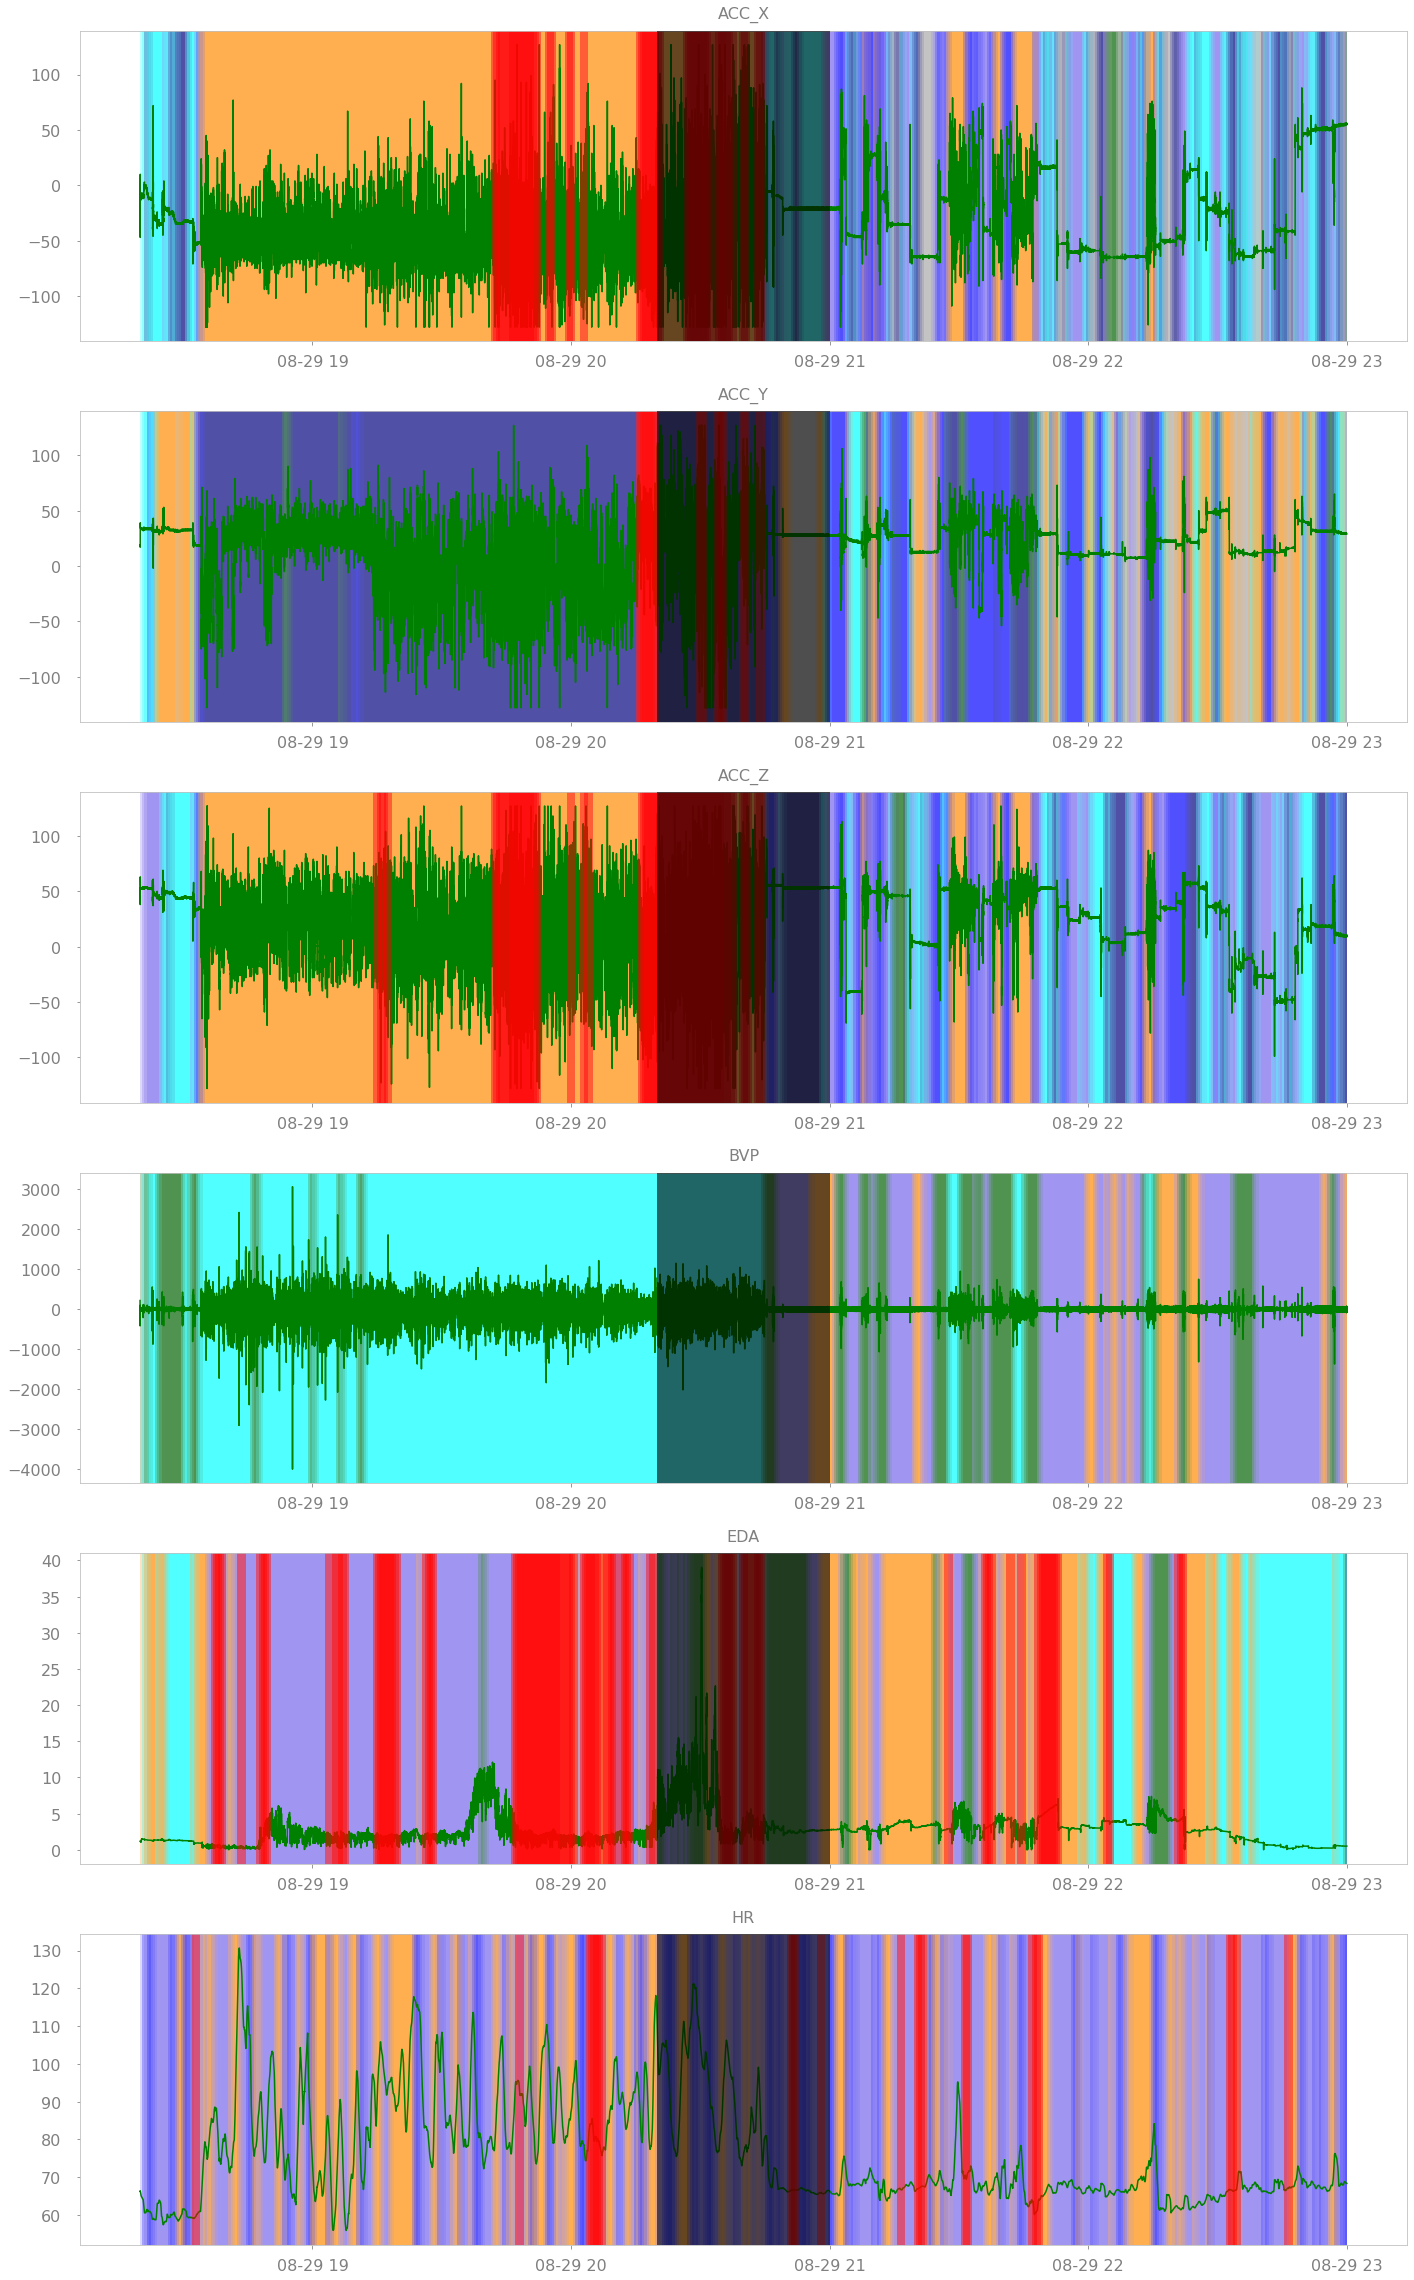

CPU times: user 36.5 s, sys: 1.8 s, total: 38.3 s
Wall time: 36.7 s


In [6]:
%%time

import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams["figure.figsize"] = (20, 32)

test_end_ts = test_start_ts + test_original["HR"].shape[0]
test_agitation = agitation_num
new_test_start_ts = max(test_start_ts, agitation_start_ts[test_agitation] - 60 * 120)
new_test_end_ts = min(agitation_end_ts[test_agitation] + 60 * 120, test_end_ts)
test_start_index = new_test_start_ts - test_start_ts
test_end_index = (test_end_ts - test_start_ts) - (test_end_ts - new_test_end_ts)
PAIs = []

test_data = {}
for i, category in enumerate(DATA_CATEGORIES):
#     if i == 3:
#         break
#     if i != 5:
#         continue
    test_data[category] = test_original[category].iloc[
        int(test_start_index*hz[i]):int((test_end_index*hz[i])),
        :
    ].reset_index(drop=True)
    pipelines[i].anomaly_sensitivity = 1.5
    predictions = pd.DataFrame(pipelines[i].predict(test_data[category]))
    a = predictions[predictions[0] == True].size
    A = predictions.size

    test_data["ts"] = pd.DataFrame([datetime.fromtimestamp(new_test_start_ts + (j / hz[i])) for j in range(test_data[category].shape[0])])
    df = pd.concat([test_data[category], test_data["ts"]], axis=1)
    df.columns = ["data", "ts"]
    
    plt.subplot(len(DATA_CATEGORIES), 1, i+1)
    plt.plot(df["ts"], df["data"], color="green", markersize=2, zorder=1)

    # highlight true anomalies
#     for i, ts in enumerate(agitation_ts):
    for j in range(len(agitation_start_ts)):
        if j == 0:
            continue
#         if new_test_end_ts < ts or ts < new_test_start_ts:
#             continue
#         print(f"Start: {agitation_start_ts[j]}")
        beg = datetime.fromtimestamp(agitation_start_ts[j])
        end = datetime.fromtimestamp(agitation_end_ts[j])
        plt.axvspan(beg, end, color='black', alpha=0.6, lw=0, zorder=3)

    # highlight anomalies
    hit = False
    anoms = list(predictions[predictions[0] == True].index)
    for index in anoms:
        beg = test_data["ts"].iloc[(index * WINDOW_SIZE[i]) - (index * WINDOW_OVERLAP[i])]
        end = test_data["ts"].iloc[min(((index + 1) * WINDOW_SIZE[i]) - (index * WINDOW_OVERLAP[i]), test_data["ts"].shape[0] - 1)]
        plt.axvspan(beg, end, color='red', alpha=0.5, lw=0, zorder=2)
        if (beg[0] >= datetime.fromtimestamp(agitation_start_ts[1])
            and end[0] <= datetime.fromtimestamp(agitation_end_ts[1]) 
        ):
            hit = True
            
    PAIs.append(hit * (A/a))

    # highlight non-anomalies by cluster
    colors = ["#7766ee", "blue", "darkgreen", "darkorange", 'cyan', "navy", "darkgray", "purple", "white"]
    non_anomalies = predictions[predictions[0] == False]
    for index in non_anomalies.index:
        beg = test_data["ts"].iloc[(index * WINDOW_SIZE[i]) - (index * WINDOW_OVERLAP[i])]
        end = test_data["ts"].iloc[min(((index + 1) * WINDOW_SIZE[i]) - (index * WINDOW_OVERLAP[i]), test_data["ts"].shape[0] - 1)]
        color = colors[pipelines[i].closest_match[index]]
        plt.axvspan(beg, end, color=color, alpha=0.25, lw=0, zorder=0)

    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16, y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5', pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title(f"{category}", fontsize=16, y=1.02, color='.5')

plt.tight_layout(pad=2)
plt.show()

In [31]:
for category, PAI in zip(DATA_CATEGORIES, PAIs):
    print(f"{category}: {PAI}")

ACC_X: 7.466666666666667
ACC_Y: 31.11111111111111
ACC_Z: 8.235294117647058
BVP: nan
EDA: 5.185185185185185
HR: 28.0


In [8]:
from IPython.display import Image, display
from IPython.core.display import HTML
for i, pipeline in enumerate(pipelines):
    print(DATA_CATEGORIES[i])
    for i, file in enumerate(pipeline.cluster_PFSA_pngs):
        print(f"Cluster {i} PFSA")
        display(Image(url=f"{file}.png", width=300))

ACC_X
Cluster 0 PFSA


Cluster 1 PFSA


Cluster 2 PFSA


Cluster 3 PFSA


Cluster 4 PFSA


Cluster 5 PFSA


Cluster 6 PFSA


ACC_Y
Cluster 0 PFSA


Cluster 1 PFSA


Cluster 2 PFSA


Cluster 3 PFSA


Cluster 4 PFSA


Cluster 5 PFSA


ACC_Z
Cluster 0 PFSA


Cluster 1 PFSA


Cluster 2 PFSA


Cluster 3 PFSA


Cluster 4 PFSA


Cluster 5 PFSA


Cluster 6 PFSA


Cluster 7 PFSA


BVP
Cluster 0 PFSA


Cluster 1 PFSA


Cluster 2 PFSA


Cluster 3 PFSA


Cluster 4 PFSA


EDA
Cluster 0 PFSA


Cluster 1 PFSA


Cluster 2 PFSA


Cluster 3 PFSA


Cluster 4 PFSA


Cluster 5 PFSA


HR
Cluster 0 PFSA


Cluster 1 PFSA


Cluster 2 PFSA


Cluster 3 PFSA


Cluster 4 PFSA


Cluster 5 PFSA


Cluster 6 PFSA
